Networks - Final Project

"Is there an optimal road or road structure to close and convert to a public use space in Barcelona that minimizes the impact on traffic?"

-Clarice Mottet, Amber Walker, Mox Ballo

General Notes:

There are only 930 nodes in the link_file, there are 2522 edges in the link_file (haven't checked for duplicates). There are no duplicate edges (based on origin_node to to_node)

website link that the frank wolfe code is from

https://nbviewer.org/github/PyTrans/Urban-Network-Analysis/blob/master/Trip_Assignment-Frank-Wolfe_Algorithm.ipynb

website link that the TransportationNetworks code is from

https://github.com/PyTrans/Urban-Network-Analysis/tree/master/pytrans/UrbanNetworkAnalysis

SUPER IMPORTANT

I saw in the TransportationNetworks.py file that their initial alpha was .5 but everywhere said it should be .15, so I changed it to .15 in my file.

Because there is no node_file and I have to create it, I had to alter some of the TransportationNetworks.py code

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
#libraries

import pandas as pd
import numpy as np
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.misc import derivative
# import TransportationNetworks as tn

# import os
# os.chdir('/content/drive/My Drive/networks_final_project_collab/networks_finalproject')

import TransportationNetworks_CM as tncm

# path_in_ = r'./inputs/'
# path_out_ = r'./outputs'
# path_out_results_ = r'./outputs/results'

path_in_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/'
path_out_results_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/results/'
path_out_social_ = r'/home/clarice/Documents/VSCode/Term2_Networks/final_project/networks_finalproject/outputs/social/'

In [2]:
#functions: user, based on jupyter notebook

#from website to calculate latency
def BPR(t0, xa, ca, alpha, beta):
    ta = t0*(1+alpha*(xa/ca)**beta)
    return ta

#from website: method to calculate nash equilibrium (when SO = False)
def calculateZ(theta, network, SO):
    z = 0
    for linkKey, linkVal in network.items():
        t0 = linkVal['t0']
        ca = linkVal['capa']
        beta = linkVal['beta']
        alpha = linkVal['alpha']
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        
        if SO == False:
            z += integrate.quad(lambda x: BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
        elif SO == True:
            z += list(map(lambda x : x * BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
    return z

#from website: finds nash equilibrium
def lineSearch(network, SO):
    theta = minimize_scalar(lambda x: calculateZ(x, network, SO), bounds = (0,1), method = 'Bounded')
    return theta.x

In [3]:
#functions: user, based on jupyter notebook

def initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, SO):
    #set objective and open the network
    barcelonaSubset = tncm.Network(link_file, trip_file, od_vols, origins, od_dic, links, graph)

    #CM - start of initialization

    # define output variables, network and fwResult
    network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
            'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
            'auxiliary':[], 'cost':[]} for (u, v, d) in barcelonaSubset.graph.edges(data=True)}

    fwResult = {'theta':[], 'z':[]}

    # initial all-or-nothing assignment and update link travel time(cost)
    barcelonaSubset.all_or_nothing_assignment()
    barcelonaSubset.update_linkcost()

    for linkKey, linkVal in network.items():
        linkVal['cost'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['weight'])
        linkVal['auxiliary'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)
        linkVal['flow'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)

    return barcelonaSubset, network, fwResult

#frank wolfe algorithm function
def frank_wolfe(barcelonaSubset, network, fwResult, SO):
    ## iterations
    iterNum=0
    iteration = True
    while iteration:
        iterNum += 1
        barcelonaSubset.all_or_nothing_assignment()
        barcelonaSubset.update_linkcost()
        
        # set auxiliary flow using updated link flow
        for linkKey, linkVal in network.items():
            linkVal['auxiliary'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol)
            
        # getting optimal move size (theta)
        theta = lineSearch(network, SO)
        fwResult['theta'].append(theta)
        
        # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
        for linkKey, linkVal in network.items():
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            linkVal['flow'].append(flow + theta*(aux-flow))
            
            barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
            barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
            
        # update link travel time
        barcelonaSubset.update_linkcost()
        
        # calculate objective function value
        z=0
        for linkKey, linkVal in network.items():
            linkVal['cost'].append(barcelonaSubset.graph[linkKey[0]][linkKey[1]]['weight'])
            totalcost = barcelonaSubset.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
            z+=totalcost
            
        fwResult['z'].append(z)        
            
        # convergence test
        if iterNum == 1:
            iteration = True
        else:
            if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
                iteration = False

    return barcelonaSubset, network, fwResult

def cash_overall(network):
    overall_travel_time = 0.0
    overall_total_cost = 0.0

    for (u, v, d) in network.graph.edges(data=True):
        link_obj = d['object']
        current_flow = link_obj.flow  # Assuming this gives the final flow
        t0 = link_obj.t0
        c = link_obj.capacity
        alpha = link_obj.alpha
        beta = link_obj.beta
        # Calculate the travel time with the final flow
        travel_time = BPR(t0, current_flow, c, alpha, beta)
        overall_travel_time += travel_time
        # Optionally calculate total cost (travel time * flow)
        total_cost = travel_time * current_flow
        overall_total_cost += total_cost
        # Update the network with the new travel time and total cost
        network.graph[u][v]['travel_time'] = travel_time
        network.graph[u][v]['total_cost'] = total_cost
    return network, overall_travel_time, overall_total_cost

In [4]:
#functions: user - based on TransportationNetworks

def open_trip_file_CM(trip_file):
    demand_factor=1.0
    f = open(trip_file)
    lines = f.readlines()
    f.close()

    od_vols = {}
    current_origin = None

    for line in lines:
        if current_origin == None and line.startswith("Origin"):
            origin = str(int(line.split("Origin")[1]))
            current_origin = origin

        elif current_origin != None and len(line) < 3:
            # print "blank",line,
            current_origin = None

        elif current_origin != None:
            to_process = line[0:-2]
            for el in to_process.split(";"):
                try:
                    dest = str(int(el.split(":")[0]))
                    demand = float(el.split(":")[1]) * demand_factor
                    od_vols[current_origin, dest] = demand
                except:
                    continue
    origins = [str(i) for i, j in od_vols]
    origins = list(dict.fromkeys(origins).keys())

    od_dic = {}
    for (origin, destination) in od_vols:
        if origin not in od_dic:
            od_dic[origin] = {}

        od_dic[origin][destination] = od_vols[origin, destination]
    return od_vols, origins, od_dic


def open_link_file_CM(link_file, SO):
    link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, \
                    "B": 6, "beta": 7, "V": 8}
    f = open(link_file)
    lines = f.readlines()
    f.close()

    links_info = []

    header_found = False
    for line in lines:
        if not header_found and line.startswith("~"):
            header_found = True
        elif header_found:
            links_info.append(line)

    nodes = {}
    links = []

    for line in links_info:
        data = line.split("\t")

        try:
            origin_node = str(int(data[link_fields["from"]]))
        except IndexError:
            continue
        to_node = str(int(data[link_fields["to"]]))
        capacity = float(data[link_fields["capacity"]])
        length = float(data[link_fields["length"]])
        alpha = float(data[link_fields["B"]])
        beta = float(data[link_fields["beta"]])

        if origin_node not in nodes:
            n = tncm.Node(node_id=origin_node)
            nodes[origin_node] = n

        if to_node not in nodes:
            n = tncm.Node(node_id=to_node)
            nodes[to_node] = n

        l = tncm.Link(link_id=len(links), length=length, capacity=capacity, alpha=alpha, beta=beta,
                    from_node=origin_node, to_node=to_node, flow=float(0.0), SO=SO)

        links.append(l)
    return links
    
def build_datastructure_CM(links):        
    graph = nx.DiGraph()

    for l in links:
        graph.add_edge(l.get_from_node(), l.get_to_node(), object=l, time=l.get_time())
    return graph

In [5]:
#functions: user, scratch

#used in the identify superblocks code
def common_rmv_round(graph, neighbors_node_, common_node):
    for node_ in neighbors_node_:
        neighbors_node__ = list(graph.neighbors(node_))
        for node_common in common_node:
            if node_common in neighbors_node__:
                common_node.append(node_)
                common_node = list(set(list(common_node)))
                if node_ in neighbors_node_:
                    neighbors_node_.remove(node_)        
    return neighbors_node_, common_node


def identify_superblocks_directed(graph_directed, dict_blocks):
    dict_blocks_directed = {}

    for iter_ in dict_blocks.keys():
        list_center = dict_blocks[iter_][0]
        list_corner = dict_blocks[iter_][1]
        list_outside = dict_blocks[iter_][2]

        #make sure that removing the edges to the center doesn't cause issues to the outside nodes
        #like if an outside node is only degree 2 and then one edge is removed and its an origin node
        #so the cars can't leave the node
        dict_outside_degree = {}
        for node_center in list_center:
            dict_outside_degree[node_center] = []
            for node in list_outside:
                edge_in_exists = graph_directed.has_edge(node_center, node)
                edge_out_exists = graph_directed.has_edge(node, node_center)
                if ((graph_directed.in_degree(node)-int(edge_in_exists)) >= 1)&((graph_directed.out_degree(node)-int(edge_out_exists)) >= 1):
                    dict_outside_degree[node_center].append(node)
        
        outside_clear = 0
        for node_center in list_center:
            if len(dict_outside_degree[node_center])==len(list_outside):
                outside_clear += 1
                
        list_corner_degree = []
        #make sure that there are at least two nodes on the corners that have
        #in degree > 1 and out degree > 1
        for node in list_corner:
            if (graph_directed.in_degree(node) >= 1)&(graph_directed.out_degree(node) >= 1):
                list_corner_degree.append(node)

        if (len(list_corner_degree) >= 2)&(outside_clear==4):
            dict_blocks_directed[iter_] = [list_center, list_corner, list_outside, list_corner_degree]

    return dict_blocks_directed


#function that identifies superblocks in an undirected graph
def identify_superblocks(graph_directed):
    graph = nx.Graph(graph_directed)
    list_nodes = list(graph.nodes)

    dict_blocks = {}
    iter_ = 0

    for node_i in list_nodes:
        # for node_i in list_nodes:
        neighbors_i = list(graph.neighbors(node_i))
        neighbors_i_ = list(graph.neighbors(node_i))
        nodes_common = []
        for node_j in neighbors_i:
            neighbors_j = list(graph.neighbors(node_j))
            neighbors_j.remove(node_i)
            neighbors_i_.remove(node_j)
            #make sure that you remove common neighbors in neighbors_j
            for node_j_ in neighbors_i:
                if node_j != node_j_:
                    neighbors_j_ = list(graph.neighbors(node_j_))
                    for element in neighbors_j_:
                        if element in neighbors_j:
                            neighbors_j.remove(element)
                            nodes_common.append(element)
                            nodes_common = list(set(list(nodes_common)))
            #continue to next node
            for node_k in neighbors_j:
                neighbors_k = list(graph.neighbors(node_k))
                neighbors_k.remove(node_j)
                #remove common neighbors
                neighbors_k, nodes_common = common_rmv_round(graph, neighbors_k, nodes_common)
                for node_l in neighbors_k:
                    neighbors_l = list(graph.neighbors(node_l))
                    neighbors_l.remove(node_k)
                    #now we have (node_i, node_j, node_k, node_l)
                    #go to row 2
                    for node_m in neighbors_i_:
                        #we don't want node_j to equal node_m
                        neighbors_m = list(graph.neighbors(node_m))
                        neighbors_m.remove(node_i)
                        for node_n in neighbors_m:
                            neighbors_n = list(graph.neighbors(node_n))
                            neighbors_n.remove(node_m)
                            for node_o in neighbors_n:
                                if node_o != node_j:
                                    neighbors_o = list(graph.neighbors(node_o))
                                    neighbors_o.remove(node_n)
                                    for node_p in neighbors_o:
                                        if node_p != node_k:
                                            neighbors_p = list(graph.neighbors(node_p))
                                            neighbors_p.remove(node_o)
                                            #now we have (node_m, node_n, node_o, node_p)
                                            #if first row is connected to second row
                                            if (node_j in neighbors_n)&(node_k in neighbors_o)&(node_l in neighbors_p):
                                                #continue to third row
                                                for node_q in neighbors_m:
                                                    neighbors_q = list(graph.neighbors(node_q))
                                                    neighbors_q.remove(node_m)
                                                    for node_r in neighbors_q:
                                                        neighbors_r = list(graph.neighbors(node_r))
                                                        neighbors_r.remove(node_q)
                                                        for node_s in neighbors_r:
                                                            if node_s != node_n:
                                                                neighbors_s = list(graph.neighbors(node_s))
                                                                neighbors_s.remove(node_r)
                                                                for node_t in neighbors_s:
                                                                    if node_t !=node_o:
                                                                        neighbors_t = list(graph.neighbors(node_t))
                                                                        neighbors_t.remove(node_s)
                                                                        if (node_n in neighbors_r)&(node_o in neighbors_s)&(node_p in neighbors_t):
                                                                            #now we have (node_q, node_r, node_s, node_t)
                                                                            # print("third row",node_q, node_r, node_s, node_t)
                                                                            for node_w in neighbors_q:
                                                                                neighbors_w = list(graph.neighbors(node_w))
                                                                                neighbors_w.remove(node_q)
                                                                                for node_x in neighbors_w:
                                                                                    neighbors_x = list(graph.neighbors(node_x))
                                                                                    neighbors_x.remove(node_w)
                                                                                    for node_y in neighbors_x:
                                                                                        neighbors_y = list(graph.neighbors(node_y))
                                                                                        neighbors_y.remove(node_x)
                                                                                        for node_z in neighbors_y:
                                                                                            if node_z != node_s:
                                                                                                neighbors_z = list(graph.neighbors(node_z))
                                                                                                neighbors_z.remove(node_y)
                                                                                                if (node_r in neighbors_x)&(node_s in neighbors_y)&(node_t in neighbors_z):
                                                                                                    #document all the nodes                                                                
                                                                                                    list_center = [node_n, node_o, node_r, node_s]
                                                                                                    list_corner = [node_i, node_l, node_w, node_z]
                                                                                                    list_outside = [node_i, node_j, node_k, node_l, node_m, node_p, node_q, node_t, node_w, node_x, node_y, node_z]

                                                                                                    list_center.sort()
                                                                                                    list_corner.sort()
                                                                                                    list_outside.sort()

                                                                                                    #make sure no duplicate nodes    
                                                                                                    list_center = list(set(list_center))
                                                                                                    list_outside = list(set(list_outside))

                                                                                                    #check that all nodes are degree 4
                                                                                                    all_nodes_degree4 = 0
                                                                                                    # for node in list_outside:
                                                                                                    #     if graph.degree[node] > 3:
                                                                                                    #         all_nodes_degree4 += 1
                                                                                                    for node in list_center:
                                                                                                        if graph.degree[node] == 4:
                                                                                                            all_nodes_degree4 += 1
                                                                                                    
                                                                                                    if all_nodes_degree4 == 4:
                                                                                                        # print("all nodes are degree 4")
                                                                                                        #check to make sure that the same graph isn't being added again
                                                                                                        are_equal = 0
                                                                                                        for prev in dict_blocks.keys():
                                                                                                            if (dict_blocks[prev][0] == list_center)&(dict_blocks[prev][2] == list_outside):
                                                                                                                are_equal += 1
                                                                                                        if are_equal == 0:
                                                                                                            #add the new superblock to the dictionary
                                                                                                            # print(iter_)
                                                                                                            dict_blocks[iter_] = [list_center, list_corner, list_outside]
                                                                                                            iter_ += 1
    print("Number of superblocks",len(dict_blocks.keys()))
    dict_blocks_directed = identify_superblocks_directed(graph_directed, dict_blocks)
    print("Number of superblocks directed",len(dict_blocks_directed.keys()))
    return dict_blocks_directed, dict_blocks

#this is code that updates the trips file by removing a superblock
def update_od_vols(list_dict_blocks_directed_iter, od_vols):
    list_center = list_dict_blocks_directed_iter[0]
    list_corner_degree = list_dict_blocks_directed_iter[3]

    in_corner_node = list_corner_degree[0]
    out_corner_node = list_corner_degree[1]

    #make a copy
    od_vols_out = {}
    for key_ in od_vols.keys():
        od_vols_out[key_] = od_vols[key_]

    #compile the relevant 
    origin_demand_center = []
    dest_demand_center = []
    for key_ in od_vols_out.keys():
        for node_center in list_center:
            #compile the center starting nodes
            if str(node_center) == key_[0]:
                origin_demand_center.append(key_)
            #compile the in node replacement
            if str(node_center) == key_[1]:
                dest_demand_center.append(key_)

    #update the origin connections
    for connection in origin_demand_center:
        #create an update connection
        if (str(in_corner_node) == connection[1])|(int(connection[1]) in list_center):
            update_connection = (str(in_corner_node),str(out_corner_node))
        else:
            update_connection = (str(in_corner_node),connection[1])
        if update_connection in list(od_vols_out.keys()):
            od_vols_out[update_connection] += od_vols_out[connection]
        else:
            od_vols_out[update_connection] = od_vols[connection]
        del od_vols_out[connection]

    for connection in dest_demand_center:
        if connection not in origin_demand_center:
            #create an update connection
            if (str(out_corner_node) == connection[0])|(int(connection[0]) in list_center):
                update_connection = (str(in_corner_node),str(out_corner_node))
            else:
                update_connection = (connection[0], str(out_corner_node))
            if update_connection in list(od_vols_out.keys()):
                od_vols_out[update_connection] += od_vols_out[connection]
            else:
                od_vols_out[update_connection] = od_vols_out[connection]
            del od_vols_out[connection]

    return od_vols_out

def update_trip(list_dict_blocks_directed_iter, trip_file):
    od_vols, origins, od_dic = open_trip_file_CM(trip_file)
    od_vols_out = update_od_vols(list_dict_blocks_directed_iter, od_vols)

    del origins, od_dic

    origins = [str(i) for i, j in od_vols_out]
    origins = list(dict.fromkeys(origins).keys())

    od_dic = {}
    for (origin, destination) in od_vols_out:
        if origin not in od_dic:
            od_dic[origin] = {}

        od_dic[origin][destination] = od_vols_out[origin, destination]
    return od_vols_out, origins, od_dic

#remove edges of the center nodes of the super block
def update_links(list_dict_blocks_directed_iter, link_file, SO):
    links_out = open_link_file_CM(link_file, SO)
    list_center = list_dict_blocks_directed_iter[0]

    #delete all edges tied to the center nodes of the superblock
    remove_link_index = []

    for i, l in enumerate(links_out):
        if (l.get_from_node() in list_center)|(l.get_to_node() in list_center):
            remove_link_index.append(i)

    remove_link_index.sort(reverse = True)
    for i in remove_link_index:
        del links_out[i]
    
    return links_out

def graph_w_superblock(graph, list_center, list_outside, seed):
    # Prepare node colors
    node_colors = []
    for node in graph.nodes():
        if node in list_center:
            node_colors.append('green')
        elif node in list_outside:
            node_colors.append('purple') 
        else:
            node_colors.append('blue')

    # Generate a layout
    pos = nx.spring_layout(graph, scale=1, seed = seed)
    # pos = nx.spring_layout(graph, scale=2, seed = 42)

    # Set figure size
    plt.figure(figsize=(10, 10))
    # plt.figure(figsize=(20, 20))

    # Draw the graph with specified node colors
    nx.draw_networkx(graph, pos, arrows=True, node_size=20, width=0.1, with_labels=False, alpha=0.7, node_color=node_colors)

    # Adjust plot
    plt.axis('off')
    plt.show()



In [6]:
#import data into programming environment
directory = path_in_
link_file = '{}Barcelona_net.tntp'.format(path_in_)
trip_file = '{}Barcelona_trips.tntp'.format(path_in_)

od_vols, origins, od_dic = open_trip_file_CM(trip_file)
links = open_link_file_CM(link_file, False)
graph = build_datastructure_CM(links)
#to be able to access stuff in graph


In [7]:
#Identify all eligible superblocks in the barcelona network

dict_superblocks, dict_blocks_ignore = identify_superblocks(graph)

df_superblocks = pd.DataFrame(dict_superblocks)
df_superblocks = df_superblocks.transpose()
df_superblocks.reset_index(inplace = True)
df_superblocks.columns = ['iter_','list_center','list_corner','list_outside','list_corner_degree']
df_superblocks.to_excel(path_out_+'df_superblocks_social.xlsx', index = False)

df_blocks_ignore = pd.DataFrame(dict_blocks_ignore)
df_blocks_ignore = df_blocks_ignore.transpose()
df_blocks_ignore.reset_index(inplace = True)
df_blocks_ignore.columns = ['iter_','list_center','list_corner','list_outside']
df_blocks_ignore.to_excel(path_out_+'df_blocks_all_social.xlsx', index = False)

Number of superblocks 87
Number of superblocks directed 87


In [55]:
#checking superblock nodes against trip file

list_origins = []
list_dest = []

for iter_ in dict_superblocks.keys():
    list_center = dict_superblocks[iter_][2]
    for node in list_center:
        # print(str(node))
        if str(node) in origins:
            list_origins.append(node)
        for key_ in od_dic.keys():
            list_dest_frm_origin = od_dic[key_].keys()
            if str(node) in list_dest_frm_origin:
                list_dest.append(node)

list_origins = list(set(list_origins))
list_dest = list(set(list_dest))
print("number of nodes in origin",len(list_origins))
print("number of nodes as dest",len(list_dest))
print("nodes in origin",(list_origins))
print("nodes as dest",(list_dest))

print("distinct number of origin nodes",len(origins))
dist_destination_nodes = []
for key_ in od_dic.keys():
    for node_ in od_dic[key_].keys():
        dist_destination_nodes.append(node_)
dist_destination_nodes = list(set(dist_destination_nodes))
print("distinct number of destination nodes",len(dist_destination_nodes))

origin_and_dest = []
for node_ in origins:
    if node_ in dist_destination_nodes:
        origin_and_dest.append(node_)
print("origin and dest overlap",len(origin_and_dest))

number of nodes in origin 2
number of nodes as dest 2
nodes in origin [53, 37]
nodes as dest [53, 37]
distinct number of origin nodes 97
distinct number of destination nodes 108
origin and dest overlap 97


In [66]:
dist_number_of_center = []
for iter_ in dict_superblocks.keys():
    list_center = dict_superblocks[iter_][0]
    for node in list_center:
        dist_number_of_center.append(node)
print("number of center nodes",len(dist_number_of_center))
dist_number_of_center = list(set(dist_number_of_center))
print("number of center nodes",len(dist_number_of_center))

number of center nodes 348
number of center nodes 167


In [67]:
dist_number_of_outside = []
for iter_ in dict_superblocks.keys():
    list_center = dict_superblocks[iter_][2]
    for node in list_center:
        dist_number_of_outside.append(node)
print("number of outside nodes",len(dist_number_of_outside))
dist_number_of_outside = list(set(dist_number_of_outside))
print("number of outside nodes",len(dist_number_of_outside))

number of outside nodes 1044
number of outside nodes 322


In [68]:
index_remove = []

for node_ in dist_number_of_center:
    for i, node_out in enumerate(dist_number_of_outside):
        if node_ == node_out:
            index_remove.append(i)

index_remove.sort(reverse = True)
for i in index_remove:
    del dist_number_of_outside[i]



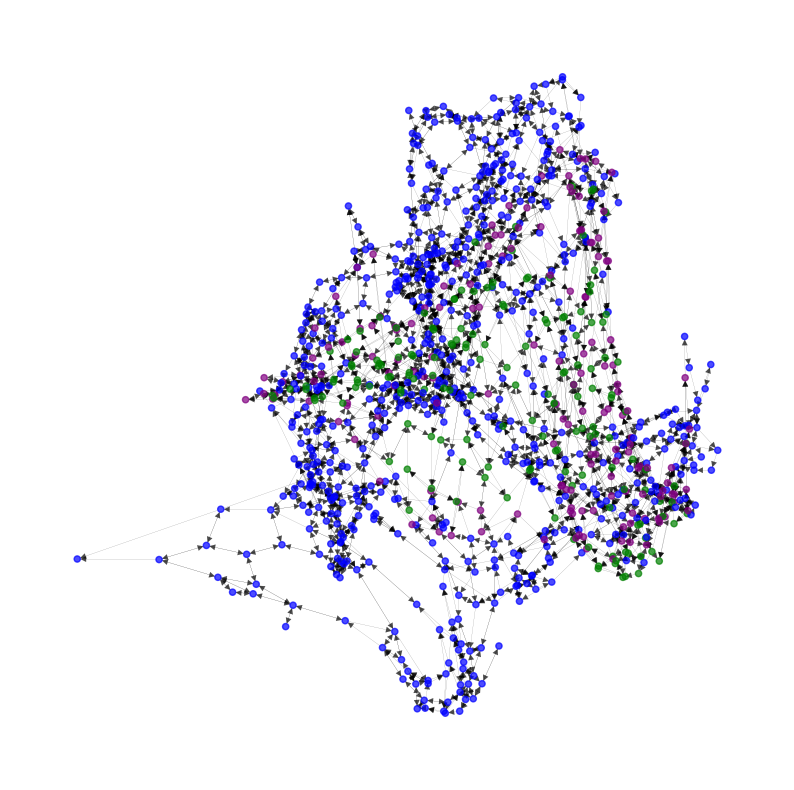

In [70]:
list_center = dist_number_of_center
list_outside = dist_number_of_outside

graph_w_superblock(graph, list_center, list_outside, 40)
# graph_w_superblock(graph, list_center, list_outside, 60)

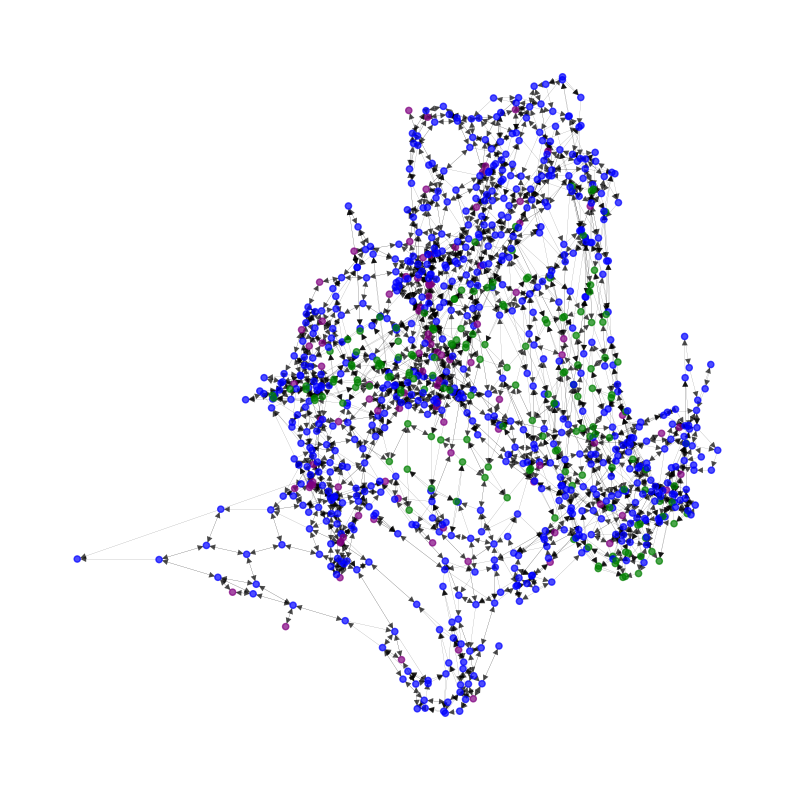

In [71]:
list_center = dist_number_of_center
list_outside = dist_number_of_outside

origins_int = [int(node_) for node_ in origins]

graph_w_superblock(graph, list_center, origins_int, 40)

In [63]:
# Assuming 'graph' is your original directed graph
# And you want a subgraph with these nodes and their connections
nodes_of_interest = [731, 732, 685, 686]
list_center = nodes_of_interest
list_outside = [736, 737, 679, 680, 681, 684, 687, 660, 727, 728, 730, 733]

# Initialize a set with your nodes of interest
all_nodes = set(nodes_of_interest)

# Add all predecessors and successors of the nodes of interest to the set
for node in nodes_of_interest:
    all_nodes.update(graph.predecessors(node))
    all_nodes.update(graph.successors(node))

# Now, create a subgraph with all these nodes
subgraph = graph.subgraph(all_nodes).copy()

graph_w_superblock(subgraph, list_center, list_outside, 60)
# graph_w_superblock(graph, list_center, list_outside, 60)

In [22]:
#calculate the total cost for the graph on the whole - nash equilibrium

#initialize graph
barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, False)

#use frank-wolfe to find nash equilibrium
barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, False)

#calculate latency
barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

df_out = pd.DataFrame([[-1, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
# df_out.to_excel(path_out_results_+'df_cost_base'+'.xlsx', index = False)


### Run through dictionary of superblocks

In [23]:
# dict_superblocks

list_ran = []

# re-work the trip file so that it doesn't include any of the center nodes from any of the graphs so the origin file stays the same for every iteration but the links will have to update depending on what super block is left in or not

In [25]:
#for loop through the dictionary of super blocks
SO = False

# dict_superblocks.keys()
for iter_ in dict_superblocks.keys():
    print(iter_)
    if iter_ not in list_ran:
        #remove the super block from the graph
        od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
        links_out = update_links(dict_superblocks[iter_], link_file, SO)

        #initialize graph
        barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

        #use frank-wolfe to find nash equilibrium
        barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

        #calculate latency
        barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

        df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
        # df_out.to_excel(path_out_results_+'df_nash_cost_'+str(iter_)+'.xlsx', index = False)
        list_ran.append(iter_)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


KeyboardInterrupt: 

In [ ]:

import time

#calculate the total cost for the graph on the whole - social equilibrium
SO = True

start_time = time.time()

#initialize graph
barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols, origins, od_dic, links, graph, SO)

#use frank-wolfe to find nash equilibrium
barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

#calculate latency
barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

df_out = pd.DataFrame([[-1, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
df_out.to_excel(path_out_social_+'df_cost_base_social_'+'.xlsx', index = False)

end_time = time.time()
print("amount of time for one run", end_time - start_time)
#4212

In [8]:

list_ran = []

SO = True

# dict_superblocks.keys() - social equilibrium
for iter_ in dict_superblocks.keys():
    if (iter_ not in list_ran) & (iter_ > 34) & (iter_ < 56):
        print(iter_)
        #remove the super block from the graph
        od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
        links_out = update_links(dict_superblocks[iter_], link_file, SO)

        #initialize graph
        barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

        #use frank-wolfe to find nash equilibrium
        barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

        #calculate latency
        barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

        df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
        df_out.to_excel(path_out_social_+'df_social_cost_'+str(iter_)+'.xlsx', index = False)
        list_ran.append(iter_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [ ]:
list_ran = []

SO = True

# dict_superblocks.keys() - social equilibrium
for iter_ in dict_superblocks.keys():
    print(iter_)
    if (iter_ not in list_ran) & (iter_ > 27) & (iter < 56):
        #remove the super block from the graph
        od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
        links_out = update_links(dict_superblocks[iter_], link_file, SO)

        #initialize graph
        barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

        #use frank-wolfe to find nash equilibrium
        barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

        #calculate latency
        barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

        df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
        df_out.to_excel(path_out_social_+'df_social_cost_'+str(iter_)+'.xlsx', index = False)
        list_ran.append(iter_)

In [ ]:
list_ran = []

SO = True

# dict_superblocks.keys() - social equilibrium
for iter_ in dict_superblocks.keys():
    print(iter_)
    if (iter_ not in list_ran) & (iter > 55):
        #remove the super block from the graph
        od_vols_out, origins_out, od_dic_out = update_trip(dict_superblocks[iter_], trip_file)
        links_out = update_links(dict_superblocks[iter_], link_file, SO)

        #initialize graph
        barcelonaSubset, network, fwResult = initialize(link_file, trip_file, od_vols_out, origins_out, od_dic_out, links_out, graph, SO)

        #use frank-wolfe to find nash equilibrium
        barcelonaSubset, network, fwResult = frank_wolfe(barcelonaSubset, network, fwResult, SO)

        #calculate latency
        barcelonaSubset, overall_travel_time, overall_total_cost = cash_overall(barcelonaSubset)

        df_out = pd.DataFrame([[iter_, overall_travel_time, overall_total_cost]], columns = ['block_iter','overall_travel_time','overall_total_cost'])
        df_out.to_excel(path_out_social_+'df_social_cost_'+str(iter_)+'.xlsx', index = False)
        list_ran.append(iter_)